In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [3]:
df = pd.read_excel ('data.xlsx',parse_dates=['Time'], index_col='Time')

In [4]:
df=df.drop(['Access to electricity (% of rural population with access) [1.2_ACCESS.ELECTRICITY.RURAL]','Access to Clean Fuels and Technologies for cooking (% of total population) [2.1_ACCESS.CFT.TOT]','Access to electricity (% of total population) [1.1_ACCESS.ELECTRICITY.TOT]','Access to electricity (% of urban population with access) [1.3_ACCESS.ELECTRICITY.URBAN]','Energy intensity level of primary energy','Total final energy consumption (TFEC) (TJ)','Renewable energy share of TFEC (%)','Total electricity output (GWh)','Unemploument','Population'], axis=1)

In [5]:
df.head()

,Renewable electricity output (GWh),Renewable electricity share of total electricity output (%),Renewable energy consumption (TJ),GDP,Inflation
Time,,,,,
1990-01-01,9932,23.504354,74901.56,5.667029,16.756370
1991-01-01,9900,22.349648,77488.67,1.125405,19.748540
1992-01-01,9700,21.235606,77426.89,4.472859,13.637420
1993-01-01,10485,21.936982,81250.38,2.900791,12.089790
1994-01-01,10971,22.251744,86092.79,3.973172,8.154231


In [6]:
from statsmodels.tsa.stattools import grangercausalitytests

In [7]:
df = df.dropna(axis=1)

# Step One: Test for Causation Using Granger Test

The main purpose of VAR models is forecasting and the ability of a group of variables of predicting
each other, and that's why we are interesting in granger causality. Granger causality test y
is a useful tool for characterizing the dependence among time series in reduced-form VAR models.
 It's said that variable y1 Granger Cause variable y2 if y1 is found to be helpful for
predicting y2. And if it's not, it's said that y1 fails to Granger Cause y2. To apply this test
on python we used "grangercausalitytests()" function which uses the following null and alternative
hypotheses:
Ho: The time series of variable y1 doesn't Granger Cause the time series of variable y2
H1: The time series of variable y1 Granger Cause the time series of variable y2

In [8]:
maxlag=7

In [9]:
df.head()

,Renewable electricity output (GWh),Renewable electricity share of total electricity output (%),Renewable energy consumption (TJ),GDP,Inflation
Time,,,,,
1990-01-01,9932,23.504354,74901.56,5.667029,16.756370
1991-01-01,9900,22.349648,77488.67,1.125405,19.748540
1992-01-01,9700,21.235606,77426.89,4.472859,13.637420
1993-01-01,10485,21.936982,81250.38,2.900791,12.089790
1994-01-01,10971,22.251744,86092.79,3.973172,8.154231


In [10]:
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
 
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,Renewable electricity output (GWh) _x,Renewable electricity share of total electricity output (%) _x,Renewable energy consumption (TJ)_x,GDP_x,Inflation_x
Renewable electricity output (GWh) _y,1.0,0.0,0.0,0.0,0.0001
Renewable electricity share of total electricity output (%) _y,0.0,1.0,0.0,0.0,0.0000
Renewable energy consumption (TJ)_y,0.0,0.0,1.0,0.0,0.0000
GDP_y,0.0,0.0,0.0,1.0,0.0029
Inflation_y,0.0,0.0,0.0,0.0,1.0000


The rows represent the response variable and the columns
represent the predictor variables. As it clear every combination of the variables have a P-value less than
.05, which means that every variable Granger Cause the other variables.

# Step Two: Cointegration Test

In [11]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    
    out = coint_johansen(df,-1,1)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Renewable electricity output (GWh)  ::  92.5      > 60.0627   =>   True
Renewable electricity share of total electricity output (%)  ::  55.03     > 40.1749   =>   True
Renewable energy consumption (TJ) ::  36.83     > 24.2761   =>   True
GDP    ::  20.93     > 12.3212   =>   True
Inflation ::  8.08      > 4.1296    =>   True


By performing Johanson's Cointegration test on the main variables: it was found that at level of
significant 5%, Renewable electricity output, Renewable electricity share of total electricity output,
Renewable energy consumption, GDP and Inflation have a long run statistically significant relationship.

# Splitting The Data

In [12]:
nobs = 2
df_train, df_test = df[0:-nobs], df[-nobs:]
print(df_train.shape) 
print(df_test.shape)

(24, 5)
(2, 5)


In [13]:
df_test.head()


,Renewable electricity output (GWh),Renewable electricity share of total electricity output (%),Renewable energy consumption (TJ),GDP,Inflation
Time,,,,,
2014-01-01,15513,8.870908,118541.1,3.160000e+11,10.07022
2015-01-01,15030,8.259286,119103.6,3.290000e+11,10.37049


# Make the Time Series Stationary

The stationarity of each time series of every variable has been tested by ADF test, and it was found that one diffrence is needed.

In [14]:
df_differenced = df_train.diff().dropna()

# Choosing the Optimal Order (p)

At this step, the dataset had been split to training dataset and testing dataset. The training dataset; which
consist of the first 24 observations (years); will be used to find the optimal order and to forecast the next
2 observations (years). The testing dataset will be used to compare between the actual data and the
forecasts from training dataset. The optimal order is the order of the model which minimizes the lag
selection criteria. In this study the lag selection criteria are: AIC, BIC, FPE, and HQIC. Because the
dataset is small, we compared between the first three lag orders. 

In [15]:
model = VAR(df_differenced)
for i in [1,2,3]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  78.86649184385875
BIC :  80.35427700752918
FPE :  1.9144012191928308e+34
HQIC:  79.21696929175442 

Lag Order = 2
AIC :  78.83046846817976
BIC :  81.5661224717411
FPE :  3.065571822731368e+34
HQIC:  79.42417541749397 

Lag Order = 3
AIC :  58.009247336744295
BIC :  61.99217643096026
FPE :  3.0899589486046907e+26
HQIC:  58.78675693966389 



F:\heba\New folder\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


It was found that the model of lag order
3 has the least AIC, BIC, final production error "FPE", and Hannan and Quinn information criterion
HQIC.

In [16]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 02, Jul, 2022
Time:                     20:00:16
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    56.6271
Nobs:                     20.0000    HQIC:                   53.4216
Log likelihood:          -588.335    FPE:                1.44515e+24
AIC:                      52.6441    Det(Omega_mle):     7.64804e+22
--------------------------------------------------------------------
Results for equation Renewable electricity output (GWh) 
                                                                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------------------------------------
const                                                               -2896.195698      2220.5

VAR model of order 3 has been applied on the data from 1990 to 2013. The output consists of 5
equations, every equation represents one variable at time as a dependent variable in year t and the
independent variables are all the variables in the 3 years previous to year t.
-All parameters are insignificant, so there is insignificant relationship between the Renewable electricity
output in any year and any variable in the three years before that year.
-There's no significant relationship between renewable electricity share of total electricity output in any
year and renewable electricity output in the first previous year but there's negative significant
relationship between the renewable electricity share of total electricity output in any year and
renewable electricity output in the second and the third previous year. There's a negative significant
relationship between the renewable electricity share of total electricity output and the first and the third
previous year but no significant relationship with the second previous year. There's a positive
significant relationship between the renewable electricity share of total electricity output in any year
and renewable energy consumption at the previous 3 years. There's no significant relationship between
the renewable electricity share of total electricity output in any year and GDP at the previous 3
years.There's no significant relationship between the renewable electricity share of total electricity
output in any year and inflation at the previous first and third year, but there's a significant relationship
between the renewable electricity share of total electricity output in any year and inflation at the
previous second year.
-Renewable energy consumption in one year has no significant relationship with renewable electricity
output or GDP at any 3 previous years of that year. There is a negative relationship between the
renewable energy consumption in any year and renewable electricity share of total electricity output at
the year previous of that year only. There's a positive relationship between the renewable energy
consumption in any year and the third last year of that year only. There's a negative relationship
between the renewable energy consumption in any year and the second last year of that year only.
-There's no significant relationship between the GDP in any year and any variable at any previous 3
years of that year.
-There's only a positive relationship between the inflation in one year and renewable energy
consumption in the previous year of that year, otherwise there's no significant relationship between the
inflation in any year and any variable at any 3 previous years of that year.

# Durbin Watson Test

Durbin Watson test had been applied to test whether there's a serial correlation between the residuals or
not. Durbin Watson statistics ranges from 0 to 4, and it's said that there's no autocorrelation if the value
of the statistics around 2.

In [17]:
from statsmodels.stats.stattools import durbin_watson


In [18]:
durbin_watson(model_fitted.resid)

array([2.28159012, 1.8806478 , 2.45026762, 1.50183299, 1.55966951])

In [19]:
from decimal import *

In [20]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

Renewable electricity output (GWh)  : 2.28
Renewable electricity share of total electricity output (%)  : 1.88
Renewable energy consumption (TJ) : 2.45
GDP : 1.5
Inflation : 1.56


It was found that Durbin Watson statistics for Renewable electricity output = 2.28, Renewable electricity
share of total electricity output = 1.88, Renewable energy consumption = 2.45, GDP = 1.5 and Inflation
= 1.56. It seems like that there's no autocorrelation between the residuals in the model.

# Forecasting and Evaluating

MAPE, ME, MAE, MPE and RMSE are used to evaluate the forecasting power of the model. MAPE is
the mean absolute percentage error, the mean of the sum of absolute deviation of predicted and observed
value dividing by the observed value is called mean absolute error, is one of percentage errors and are
useful because they are scale-independent, ME is the mean error, MAE is the mean absolute error which
shows the sum of the absolute difference from actual to forecast and averages them, MPE is the mean
Percentage Error and RMSE which is Root Mean squared Error.

In [21]:
lag_order = model_fitted.k_ar
print(lag_order) 

3


In [22]:
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[-6.90000000e+01, -7.21121376e-01,  2.48980000e+03,
         6.00000000e+09, -1.20026000e+00],
       [-6.30000000e+01, -4.47423354e-01, -3.14000000e+01,
         6.00000000e+09, -2.95320100e+00],
       [ 3.08000000e+02,  2.46741317e-03,  2.64050000e+03,
         7.00000000e+09,  2.35799100e+00]])

In [23]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

,Renewable electricity output (GWh) _1d,Renewable electricity share of total electricity output (%) _1d,Renewable energy consumption (TJ)_1d,GDP_1d,Inflation_1d
Time,,,,,
2014-01-01,327.698808,-0.363774,2101.532677,5.043419e+09,-2.498476
2015-01-01,-842.715016,-2.041235,-2736.695819,2.120517e+10,-1.248619


In [24]:
def invert_transformation(df_train, df_forecast, first_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [25]:
df_results = invert_transformation(df_train, df_forecast, first_diff=True) 

In [26]:
df_results.reindex(columns = ['Renewable electricity output (GWh) _forecast','Renewable electricity share of total electricity output (%) _forecast','Renewable energy consumption (TJ)_forecast','GDP_forecast','Inflation_forecast'])

,Renewable electricity output (GWh) _forecast,Renewable electricity share of total electricity output (%) _forecast,Renewable energy consumption (TJ)_forecast,GDP_forecast,Inflation_forecast
Time,,,,,
2014-01-01,15253.698808,8.518107,118148.332677,3.120434e+11,6.971244
2015-01-01,14410.983793,6.476872,115411.636858,3.332486e+11,5.722625


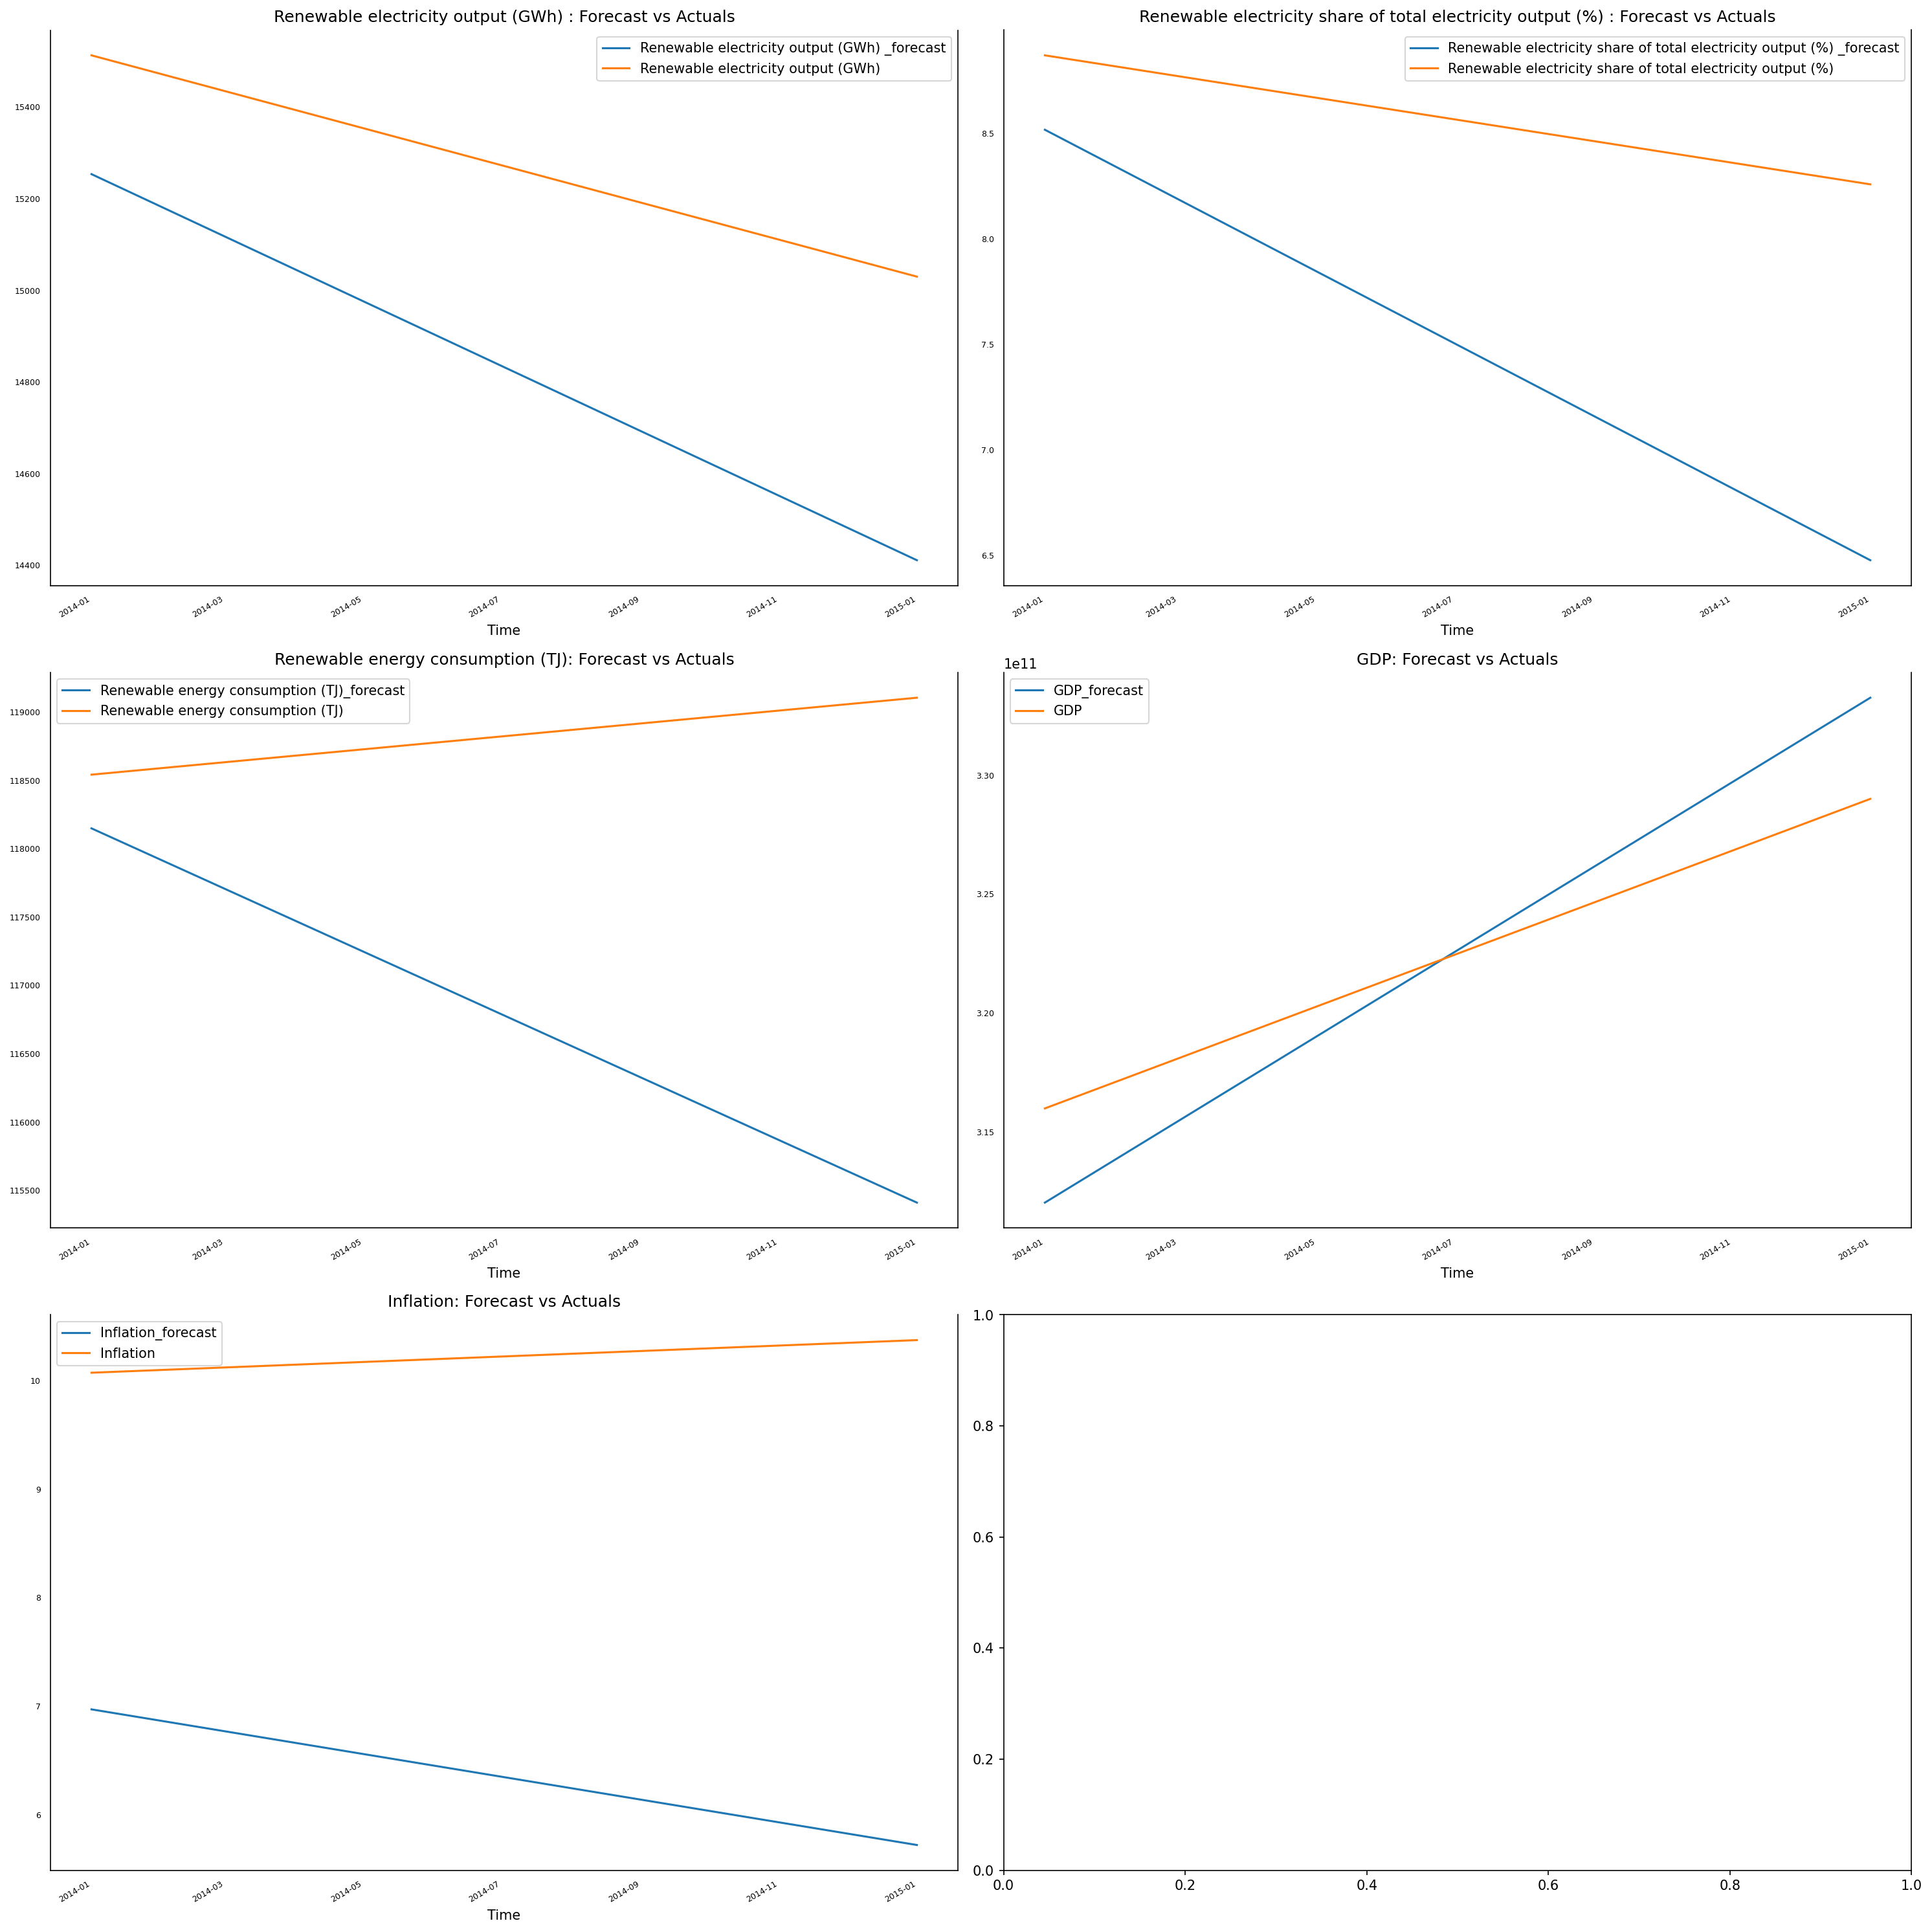

In [32]:
fig, axes = plt.subplots(nrows=int(3), ncols=2, dpi=150, figsize=(20,20))

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x')
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    plt.ylim(0)
plt.tight_layout();


-The values of Renewable electricity output in 2014 and 2015 are underestimated.
-As shown in figure the model could predict the decreasing in the Renewable electricity share of total
electricity output but with higher slope comparing to the actual. The forecasted values are less than the
actual values.
-The predicted value of 2014 is near from the actual value of 2014, unlike the predicted value of 2015
which is far from the actual value of 2015. The model predicted that the renewable energy consumption
decreased from 2014 to 2015 but the decreasing rate is much higher than the actual.
-The model predicted that the GDP will increase between 2014 and 2015 but with higher rate of
increasing comparing to the actual data. The predicted value of GDP of 2014 is less than the actual value
of GDP of 2014, but the predicted value of GDP of 2015 is higher than the actual value of GDP of 2015.
-The predicted value of inflation of 2014 and 2015 are less than the actual values of inflation of 2014 and
2015.

In [28]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
print('Forecast Accuracy of: Renewable electricity output (GWh)')
accuracy_prod = forecast_accuracy(df_results['Renewable electricity output (GWh) _forecast'].values, df_test['Renewable electricity output (GWh) '])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Renewable electricity share of total electricity output (%) ')
accuracy_prod = forecast_accuracy(df_results['Renewable electricity share of total electricity output (%) _forecast'].values, df_test['Renewable electricity share of total electricity output (%) '])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Renewable energy consumption (TJ)')
accuracy_prod = forecast_accuracy(df_results['Renewable energy consumption (TJ)_forecast'].values, df_test['Renewable energy consumption (TJ)'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: GDP')
accuracy_prod = forecast_accuracy(df_results['GDP_forecast'].values, df_test['GDP'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))
    

print('\nForecast Accuracy of: Inflation')
accuracy_prod = forecast_accuracy(df_results['Inflation_forecast'].values, df_test['Inflation'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: Renewable electricity output (GWh)
mape :  0.029
me :  -439.1587
mae :  439.1587
mpe :  -0.029
rmse :  474.562
corr :  1.0
minmax :  0.029

Forecast Accuracy of: Renewable electricity share of total electricity output (%) 
mape :  0.1278
me :  -1.0676
mae :  1.0676
mpe :  -0.1278
rmse :  1.2848
corr :  1.0
minmax :  0.1278

Forecast Accuracy of: Renewable energy consumption (TJ)
mape :  0.0172
me :  -2042.3652
mae :  2042.3652
mpe :  -0.0172
rmse :  2625.3436
corr :  -1.0
minmax :  0.0172

Forecast Accuracy of: GDP
mape :  0.0127
me :  146004906.7603
mae :  4102585945.3555
mpe :  0.0002
rmse :  4105183171.5316
corr :  1.0
minmax :  0.0126

Forecast Accuracy of: Inflation
mape :  0.378
me :  -3.8734
mae :  3.8734
mpe :  -0.378
rmse :  3.9501
corr :  -1.0
minmax :  0.378


<ipython-input-28-18c18b898e3d>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-28-18c18b898e3d>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [30]:
df_diff = df.diff()
df_diff.replace([np.inf, -np.inf], np.nan, inplace=True)
df_diff=df_diff.dropna()


In [31]:
df_diff.head()

,Renewable electricity output (GWh),Renewable electricity share of total electricity output (%),Renewable energy consumption (TJ),GDP,Inflation
Time,,,,,
1991-01-01,-32.0,-1.154707,2587.11,-4.541624,2.992170
1992-01-01,-200.0,-1.114042,-61.78,3.347454,-6.111120
1993-01-01,785.0,0.701376,3823.49,-1.572068,-1.547630
1994-01-01,486.0,0.314762,4842.41,1.072381,-3.935559
1995-01-01,442.0,-0.303667,-1029.74,0.669287,7.587999


In [32]:
model = VAR(df_diff)
model_fitted = model.fit(3)
model_fitted.summary()

F:\heba\New folder\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 28, Jun, 2022
Time:                     01:40:44
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    74.8530
Nobs:                     22.0000    HQIC:                   71.8202
Log likelihood:          -855.825    FPE:                4.31404e+31
AIC:                      70.8856    Det(Omega_mle):     2.80595e+30
--------------------------------------------------------------------
Results for equation Renewable electricity output (GWh) 
                                                                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------------------------------------
const                                                               -1909.117612      1571.4

In [33]:
import seaborn as sns
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

NameError: name 'results_aic' is not defined